In [3]:
import numpy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data
import matplotlib.pyplot as plt

data=pd.read_excel('C:/Users/XHM/Desktop/data/TFT/TFT_train.xlsx',engine='openpyxl')
all_input=data[['Vdrain','Vgate','W/L']].values
#all_output=data['Idrain']
minmax=preprocessing.MinMaxScaler()
all_output=minmax.fit_transform(data['Idrain'].values.reshape(-1,1))

(x_train,x_test,y_train,y_test)=train_test_split(all_input,all_output,train_size=0.8,
                                                 random_state=0)
#标准化处理
scale=StandardScaler()
x_train_s=minmax.fit_transform(x_train)
x_test_s=minmax.fit_transform(x_test)



#数据类型处理
train_xt=torch.from_numpy(x_train_s.astype(np.float32))
train_yt=torch.from_numpy(y_train)
test_xt=torch.from_numpy(x_test_s.astype(np.float32))
test_yt=torch.from_numpy(y_test)
#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt.float())
test_data=Data.TensorDataset(test_xt,test_yt.float())

train_loader=Data.DataLoader(dataset=train_data,batch_size=64,shuffle=True,num_workers=0)


In [4]:
import numpy
#搭建MLP回归模型
class MLPregression(nn.Module):
    def __init__(self,p):
        super(MLPregression,self).__init__()
        self.p=p
        #定义第一个隐藏层
        self.input=nn.Linear(in_features=3,out_features=60,bias=True)
        #定义第二个隐藏层
        self.hidden2=nn.Linear(60,100)
        #回归预测层
        self.predict=nn.Linear(100,1)
        
        self.input.weight.data=self.p[0:180].reshape((60,3))
        self.input.bias.data=self.p[180:240].reshape((60,))
        self.hidden2.weight.data=self.p[240:6240].reshape((100,60))
        self.hidden2.bias.data=self.p[6240:6340].reshape((100,))
        self.predict.weight.data=self.p[6340:6440].reshape((1,100))
        self.predict.bias.data=self.p[6440:6441]
    def forward(self,x):
        x=torch.tanh(self.input(x))
        x=torch.tanh(self.hidden2(x))
        output=self.predict(x)
        return output[:,0]
        
#mlpreg.load_state_dict(torch.load("C:/Users/XHM/LEVIST/DIST/mlp_init_nosgd.pth"))

def fitness(x):
    mlpreg=MLPregression(p=x) 
    loss_func=nn.MSELoss()
    train_loss_all=[]
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x)
        loss=loss_func(output,b_y)
    return loss


E:\Install\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


############ Generation 1 ############
最好的位置：tensor([0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011])
最小的loss：0.04176587611436844
############ Generation 2 ############
最好的位置：tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010])
最小的loss：0.005079639609903097
############ Generation 3 ############
最好的位置：tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010])
最小的loss：0.021133821457624435
############ Generation 4 ############
最好的位置：tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010])
最小的loss：0.057389914989471436
############ Generation 5 ############
最好的位置：tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0477])
最小的loss：0.036705754697322845
############ Generation 6 ############
最好的位置：tensor([0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0010])
最小的loss：0.02594926953315735
############ Generation 7 ############
最好的位置：tensor([0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0010])
最小的loss：0.017309419810771942
############ Generation 8 ############
最好的位

AttributeError: 'list' object has no attribute 'detach'

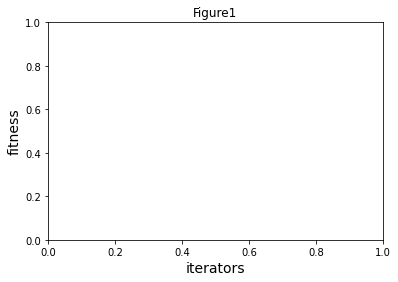

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
class PSO():
    def __init__(self, parameters):
        """
        particle swarm optimization
        parameter: a list type, like [NGEN, pop_size, var_num_min, var_num_max]
        """
        # 初始化
        self.iters = parameters[0]    # 迭代的代数
        self.pop_size = 100   # 种群大小
        self.var_num =6441   # 变量个数
        self.bound = []                 # 变量的约束范围
        self.bound.append(parameters[2])
        self.bound.append(parameters[3])
 
        self.pop_x = torch.zeros((self.pop_size, self.var_num))    # 所有粒子的位置
        self.pop_v = torch.zeros((self.pop_size, self.var_num))    # 所有粒子的速度
        self.p_best = torch.zeros((self.pop_size, self.var_num))   # 每个粒子最优的位置
        self.g_best = torch.zeros((self.var_num))   # 全局最优的位置
 
        # 初始化第0代初始全局最优解
        temp = 0.1
        for i in range(50):
            for j in range(self.var_num):
                self.pop_x[i][j] = random.uniform(self.bound[0][j], self.bound[1][j])
                self.pop_v[i][j] = random.uniform(0, 1)
            self.p_best[i] = self.pop_x[i]      # 储存最优的个体
            fit = fitness(self.p_best[i])
            if fit < temp:
                self.g_best = self.p_best[i]
                temp = fit
    def update_operator(self, pop_size):
        """
        更新算子：更新下一时刻的位置和速度
        """
        c1 = 2     # 学习因子，一般为2
        c2 = 2
        w = 0.4    # 自身权重因子
        for i in range(self.pop_size):
            # 更新速度
            self.pop_v[i] = w * self.pop_v[i] + c1 * random.uniform(0, 1) * (
                        self.p_best[i] - self.pop_x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.pop_x[i])
            # 更新位置
            self.pop_x[i] = self.pop_x[i] + self.pop_v[i]
            # 越界保护
            for j in range(self.var_num):
                if self.pop_x[i][j] < self.bound[0][j]:
                    self.pop_x[i][j] = self.bound[0][j]
                if self.pop_x[i][j] > self.bound[1][j]:
                    self.pop_x[i][j] = self.bound[1][j]
            # 更新p_best和g_best

            if fitness(self.pop_x[i]) < fitness(self.p_best[i]):
                self.p_best[i] = self.pop_x[i]
                #print('size of g_best',self.g_best.size())
            if fitness(self.pop_x[i]) < fitness(self.g_best):
                self.g_best = self.pop_x[i]
 
    def main(self):
        popobj = []
        self.ng_best = torch.zeros((1, self.var_num))[0]
        for gen in range(self.iters):
            self.update_operator(self.pop_size)
            popobj.append(fitness(self.g_best))
            print('############ Generation {} ############'.format(str(gen + 1)))
            
            if fitness(self.g_best) < fitness(self.ng_best):
                self.ng_best = self.g_best.clone()
            print('最好的位置：{}'.format(self.ng_best))
            print('最小的loss：{}'.format(fitness(self.ng_best)))
        print("---- End of (successful) Searching ----")
 
        plt.figure()
        plt.title("Figure1")
        plt.xlabel("iterators", size=14)
        plt.ylabel("fitness", size=14)
        t = [t for t in range(self.iters)]
        plt.plot(t, popobj.detach().numpy(), color='b', linewidth=2)
        plt.show()
        
if __name__ == '__main__':
    iters= 50
    '''popsize = X_train.shape[0]'''
    popsize=6441
    low = [0.001]*6441
    up = [10]*6441
    parameters = [iters, popsize, low, up]
    pso = PSO(parameters)
    pso.main()

In [10]:
a=pso.ng_best   #取出最优的参数

In [12]:
torch.save(a,"C:/Users/XHM/LEVIST/DIST/TFT_a_nosgd.pth")    # 保存Tensor为pth文件
b=torch.load("C:/Users/XHM/LEVIST/DIST/TFT_a_nosgd.pth")   # 加载出这个参数

import numpy
#搭建MLP回归模型
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        p=b
        self.input=nn.Linear(in_features=3,out_features=60,bias=True)
        #定义第二个隐藏层
        self.hidden2=nn.Linear(60,100)
        #回归预测层
        self.predict=nn.Linear(100,1)
        
        self.input.weight.data=p[0:180].reshape((60,3))
        self.input.bias.data=p[180:240].reshape((60,))
        self.hidden2.weight.data=p[240:6240].reshape((100,60))
        self.hidden2.bias.data=p[6240:6340].reshape((100,))
        self.predict.weight.data=p[6340:6440].reshape((1,100))
        self.predict.bias.data=p[6440:6441]
    def forward(self,x):
        x=torch.tanh(self.input(x))
        x=torch.tanh(self.hidden2(x))
        output=self.predict(x)
        return output[:,0]

mlp=MLPregression()
torch.save(mlp.state_dict(),"C:/Users/XHM/LEVIST/DIST/TFT_init.pth")    #保存模型的参数
print(mlp.input.weight.data)

tensor([[1.0000e-03, 1.0000e-03, 2.5584e-02],
        [1.6906e-03, 1.0000e-03, 1.8719e-03],
        [5.1983e+00, 1.0000e-03, 1.8268e-03],
        [1.0000e-03, 1.0000e-03, 1.0000e-03],
        [1.8889e-03, 1.0000e-03, 5.7058e-03],
        [4.1526e-02, 1.4891e-03, 1.0000e-03],
        [1.0338e-02, 1.0000e-03, 1.0000e-03],
        [1.0000e-03, 1.0000e-03, 1.0000e-03],
        [1.0000e-03, 2.3218e-02, 1.0000e-03],
        [1.9533e-01, 6.1434e-03, 1.5863e-02],
        [5.6802e-03, 7.3034e-03, 1.8863e-03],
        [2.9182e-03, 1.0000e-03, 1.0000e-03],
        [3.2531e-03, 1.6211e-03, 1.6459e-03],
        [1.0000e-03, 1.0000e-03, 1.0000e-03],
        [1.0000e-03, 1.7915e-03, 1.0000e-03],
        [1.0000e-03, 1.8966e-02, 1.6145e-03],
        [4.0856e-02, 1.6615e-03, 1.0000e-03],
        [1.0000e-03, 1.8663e-03, 1.0000e-03],
        [1.0000e-03, 1.0000e-03, 1.6454e-03],
        [1.9526e-01, 1.0000e-03, 1.3343e+00],
        [1.0000e-03, 1.0000e-03, 5.1712e+00],
        [1.0000e-03, 1.0000e-03, 6